![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Tokenización de textos  

En este taller podrán poner en práctica sus conocimientos sobre preprocesamiento de texto (tokenización). El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos detección de toxicidad en comentarios

En este taller se usará el conjunto de datos de detección de toxicidad en comentarios de la base de datos de Kaggle. Cada observación es un comentario que tiene como variable objetivo (target) la probabilidad de ser un comentario tóxico. El objetivo es predecir la toxicidad de cada comentario. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data).

In [63]:
import warnings
warnings.filterwarnings('ignore')

In [64]:
# Importación librerías
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
%matplotlib inline

In [65]:
# Carga de datos de archivos .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/Toxicity.zip')
df = df[['id','comment_text', 'target']]
df.head()

,id,comment_text,target
0,6101457,What are you talking about? What group do Pete...,0.0
1,5342103,"NO!, Let him, we need a Conservative government.",0.0
2,743361,"Perhaps he took the ""power out of the Cardinal...",0.2
3,551008,"As always, yours is dripping with sarcasm, whi...",0.0
4,865998,The dirty little secret is that the price rang...,0.3


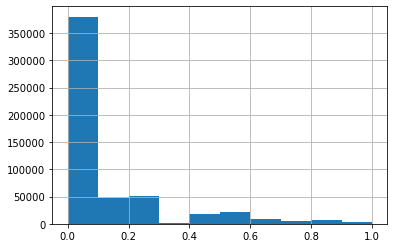

In [66]:
# Impresión histograma de variable de interés (y)
df.target.hist()

In [67]:
# Separación de variable de interés (y)
y = df.target
y.describe()

count    541462.000000
mean          0.102991
std           0.196979
min           0.000000
25%           0.000000
50%           0.000000
75%           0.166667
max           1.000000
Name: target, dtype: float64

In [68]:
# Separación de variables predictoras (X), solo se considera el texto de la noticia
X = df.comment_text

In [69]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Punto 1 - Tokenización con CountVectorizer

En la celda 1 creen y entrenen el modelo de regresión de su preferencia, para que prediga la probabilidad de que un comentario sea tóxico, usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** para preprocesar los comentarios y presenten el desempeño del modelo con la métrica del MSE.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [70]:
# Celda 1

# Creación de matrices de documentos usando CountVectorizer con todo en vocabulario en minúsculas.
vect_1 = CountVectorizer() 
X_train_1 = vect_1.fit_transform(X_train) # Preprocesamiento en train
X_test_1 = vect_1.transform(X_test) # Preprocesamiento en test

En la celda anterior **hemos creado la matriz de tokens para el conjunto de train y también hemos aplicado la misma transformación al conjunto de test** para ingresarlos al modelo predictivo. En la siguiente celda vamos a revisar **la cantidad de comentarios que tiene el conjunto de train y test, al igual que la cantidad de tokens** (característias/columnas) del diccionario que produjo el conjunto train (que debe ser igual en los dos conjuntos):

In [71]:
# Impresión del tamaño de los set de train y test
print("X_train_1 tiene {} comentarios y {} tokens".format(*X_train_1.shape))
print("X_test_1 tiene {} comentarios y {} tokens".format(*X_test_1.shape))

X_train_1 tiene 362779 comentarios y 141176 tokens
X_test_1 tiene 178683 comentarios y 141176 tokens


Ahora vamos a **entrenar y calibrar el modelo predictivo de Random Forest**. Solo variamos un parámetro porque la calibración con GridSearchCV empezó a tomar demasiado tiempo modificando varios de los parámetros (**básicamente solo usamos validación cruzada con 2 folds y variación del parámetro *max_depth***):

In [72]:
# Calibración y entrenamiento del modelo Ramdon Forest:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor


# Definición del modelo Random Forest
rfr=RandomForestRegressor(random_state=42,n_jobs=-1)
# Parámetros para calibración
param_grid = { 
    #'n_estimators': [200, 300],
    'n_estimators': [100],
    #'max_features': ['auto', 'sqrt', 'log2'],
    'max_features': ['sqrt'],
    'max_depth' : [4,5,6,7,8],
    #'max_depth' : [4],
    #'criterion' :['squared_error', 'absolute_error', 'poisson']
}
# Entrenamiento para calibración con GridSearchCV 
CV_rfr = GridSearchCV(estimator=rfr, param_grid=param_grid, cv= 2)
CV_rfr.fit(X_train_1, y_train)

GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=N

A partir de **la calibración con GridSearchCV podemos conocer ahora los mejores parámetros (solo variamos *max_depth*), los cuales son:**

In [73]:
# Mejores parámetros de la calibración
CV_rfr.best_params_

{'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 100}

Con el único parámetro anteriormente calibrado podemos entrenar el **modelo final para predecir la probabilidad de que un 
comentario sea tóxico:**

In [74]:
# Entrenamiento del modelo con parámetros calibrados:
rfr_1=RandomForestRegressor(max_features='sqrt', n_estimators= 100, max_depth=8, random_state=42, n_jobs=-1)
rfr_1.fit(X_train_1, y_train)
# Predicciones de probabilidad de toxicidad sobre el conjunto Test
y_pred_1=rfr_1.predict(X_test_1)

Finalmente, procedemos a calcular **el desempeño del modelo en el conjunto de test a partir del MSE:**

In [94]:
# Función que calcula el MSE
def mse (real, pred):
    real, pred = np.array (real), np.array (pred)
    return np.square (np.subtract (real, pred)). mean () 

# Cálculo del MSE
mse_1 = mse(y_test, y_pred_1)
print('El valor del MSE para nuestro modelo con tokenización por palabras es: {}'.format(mse(y_test, y_pred_1)))

El valor del MSE para nuestro modelo con tokenización por palabras es: 0.0380374843136335


## Punto 2 - Tokenización con CountVectorizer y trigramas

En la celda 2 creen y entrenen el mismo modelo de regresión del punto anterior (es decir si usaron un RandomForestRegresor usen nuevamente ese regresor), para que prediga la probabilidad de que un comentario sea tóxico, usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer **considerando trigramas** para preprocesar los comentarios y presenten el desempeño del modelo con la métrica del MSE.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [76]:
# Celda 2

# Creación de matrices de documentos usando CountVectorizer con trigramas.
vect_2 = CountVectorizer(ngram_range=(3, 3)) 
X_train_2 = vect_2.fit_transform(X_train) # Preprocesamiento en train
X_test_2 = vect_2.transform(X_test) # Preprocesamiento en test

En la celda anterior **hemos creado la matriz de tokens con trigramas para el conjunto de train y también hemos aplicado la misma transformación al conjunto de test** para ingresarlos al modelo predictivo. En la siguiente celda vamos a revisar **la cantidad de comentarios que tiene el conjunto de train y test, al igual que la cantidad de tokens** (característias/columnas) del diccionario que produjo el conjunto train (que debe ser igual en los dos conjuntos):

In [77]:
# Impresión del tamaño de los set de train y test
print("X_train_2 tiene {} comentarios y {} tokens".format(*X_train_2.shape))
print("X_test_2 tiene {} comentarios y {} tokens".format(*X_test_2.shape))

X_train_2 tiene 362779 comentarios y 10546378 tokens
X_test_2 tiene 178683 comentarios y 10546378 tokens


Ahora vamos a **entrenar y calibrar el modelo predictivo de Random Forest**. Solo variamos un parámetro porque la calibración con GridSearchCV empezó a tomar demasiado tiempo modificando varios de los parámetros (**básicamente solo usamos validación cruzada con 2 folds y variación del parámetro *max_depth***):

In [78]:
# Definición del modelo Random Forest
rfr=RandomForestRegressor(random_state=42,n_jobs=-1)
# Parámetros para calibración
param_grid = { 
    #'n_estimators': [200, 300],
    'n_estimators': [100],
    #'max_features': ['auto', 'sqrt', 'log2'],
    'max_features': ['sqrt'],
    'max_depth' : [4,5,6,7,8],
    #'max_depth' : [4],
    #'criterion' :['squared_error', 'absolute_error', 'poisson']
}
# Entrenamiento para calibración con GridSearchCV 
CV_rfr = GridSearchCV(estimator=rfr, param_grid=param_grid, cv= 2)
CV_rfr.fit(X_train_2, y_train)

GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=N

A partir de **la calibración con GridSearchCV podemos conocer ahora los mejores parámetros (solo variamos *max_depth*), los cuales son:**

In [79]:
# Mejores parámetros de la calibración
CV_rfr.best_params_

{'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 100}

Con el único parámetro anteriormente calibrado podemos entrenar el **modelo final para predecir la probabilidad de que un 
comentario sea tóxico:**

In [80]:
# Entrenamiento del modelo con parámetros calibrados:
rfr_2=RandomForestRegressor(max_features='sqrt', n_estimators= 100, max_depth=8, random_state=42, n_jobs=-1)
rfr_2.fit(X_train_2, y_train)
# Predicciones de probabilidad de toxicidad sobre el conjunto Test
y_pred_2=rfr_2.predict(X_test_2)

Finalmente, procedemos a calcular **el desempeño del modelo en el conjunto de test a partir del MSE:**

In [95]:
# Cálculo del MSE
mse_2 = mse(y_test, y_pred_2)
print('El valor del MSE para nuestro modelo con tokenización por trigramas es: {}'.format(mse(y_test, y_pred_2)))

El valor del MSE para nuestro modelo con tokenización por trigramas es: 0.03900371189341457


## Punto 3 - TfidfVectorizer

Investigen sobre la función TfidfVectorizer. En la celda de texto 3, expliquen en qué consiste esta técnica de tokenización (describanla y expliquen su funcionamiento) y cúales son las ventajas o deventajas de su uso al compararlo con la función CountVectorizer.

#Celda 3

## TfidfVectorizer

###  Siglas
**TF-IDF son las siglas de Term Frequency Inverse Document Frequency**. Este es un algoritmo para transformar el texto en una representación significativa de números que se utilizan en el algoritmo predictivo. Algunos motores de búsqueda lo utilizan para ayudarlos a obtener mejores resultados que sean más relevantes para una consulta.


### Qué es TF-IDF
TF-IDF tiene como objetivo definir mejor la importancia de una palabra para un documento, al tiempo que tiene en cuenta la relación con otros documentos del mismo corpus (colección de documentos). Esto se realiza observando cuántas veces aparece una palabra en un documento y al mismo tiempo prestando atención a cuántas veces aparece la misma palabra en otros documentos del corpus.

La razón detrás de comparar con otros documentos es:
- una palabra que aparece con frecuencia en un documento tiene más relevancia para ese documento, lo que significa que hay una mayor probabilidad de que el documento sea sobre o en relación con esa palabra específica
- una palabra que aparece con frecuencia en más documentos puede impedirnos encontrar el documento correcto en una colección; la palabra es relevante para todos los documentos o para ninguno. De cualquier manera, no nos ayudará a filtrar un solo documento o un pequeño subconjunto de documentos de todo el conjunto.

TF-IDF es un valor que se aplica a cada palabra en cada documento de nuestro conjunto de datos. Y para cada palabra, el valor TF-IDF aumenta con cada apariencia de la palabra en un documento, pero disminuye gradualmente con cada aparición en otros documentos.

### Formulación matemática de TF-IDF
El valor de tf-idf se calcula a partir de la siguiente relación:
$$ tfidf(w,d,D) = tf(w,d)*idf(w,D) $$
donde \\(  w \\) es una palabra dada en un documento, \\(  d \\) es un documento determinado de nuestro conjunto de datos, \\( D \\) es la colección de todos los documentos, \\( tf(w,d) \\) es la frecuencia del término/palabra y \\( idf(w,D) \\) es la frecuencia inversa del documento.

El primer término de la multiplicación, \\( tf(w,d) \\), la frecuencia del término en un documento, se calcula a partir de
$$ tf(w,d) = \log(1+f(w,d)) $$
donde \\( f(w,d) \\) es la frecuencia de la palabra \\( w \\) en el documento \\( d \\).

El segundo término de la ecuación, \\( idf(w,D) \\), la frecuencia inversa del documento, se calcula a partir de 
$$ idf(w,D) = \log(\frac{N}{f(w,D)} $$
donde \\( N \\) es el número de documentos en el conjunto de datos y \\( f(w,D) \\) es la frecuencia de la palabra \\( w \\) en todo el conjunto de datos.

La fórmula  tiene una consecuencia importante de que se alcanza un alto valor del cálculo \\( tfidf \\) cuando tenemos una frecuencia de término alto \\( tf \\) en el documento dado (parámetro local) y una frecuencia de documento baja del término en toda la colección (parámetro global), \\( idf \\).

### Ventaja de TF-IDF comparado con CountVectorizer
En general los dos métodos sirven para vectorizar documentos y mientras uno aporta un valor decimal de importancia de una palabra (TfidfVectorizer), el otro brinda un conteo entero de la cantidad de apariciones de la palabra. En general, existe una ventaja debido al caracter comparativo de cierta palabra entre diferentes documentos de la colección, se puede tener **información de la importancia estadística global al usar TfidfVectorizer que al usar CountVectorizer**. Adicionalmente, podemos indicar que los dos métodos tiene una falla en distinguir información linguística de las palabras, tales como significado real de las palabras o similaridad de las palabras con otras.


### Referencias:
- [towards data science](https://towardsdatascience.com/tf-idf-explained-and-python-sklearn-implementation-b020c5e83275)
- [linkedin](https://www.linkedin.com/pulse/count-vectorizers-vs-tfidf-natural-language-processing-sheel-saket)

## Punto 4 - Tokenización con TfidfVectorizer

En la celda 4 creen y entrenen el mismo modelo de regresión del primer punto, para que prediga la probabilidad de que un comentario sea tóxico, usando los set de entrenamiento y test definidos anteriormente. Procesen los comentarios con la función **TfidfVectorizer** y presenten el desempeño del modelo con la métrica del MSE.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [82]:
# Celda 4

# Creación de matrices de documentos usando TfidfVectorizer
vect_4 = TfidfVectorizer() 
X_train_4 = vect_4.fit_transform(X_train) # Preprocesamiento en train
X_test_4 = vect_4.transform(X_test) # Preprocesamiento en test

En la celda anterior **hemos creado la matriz de tokens con TfidfVectorizer para el conjunto de train y también hemos aplicado la misma transformación al conjunto de test** para ingresarlos al modelo predictivo.

In [89]:
# Impresión del tamaño de los set de train y test
print("X_train_4 tiene {} comentarios y {} tokens".format(*X_train_4.shape))
print("X_test_4 tiene {} comentarios y {} tokens".format(*X_test_4.shape))

X_train_4 tiene 362779 comentarios y 141176 tokens
X_test_4 tiene 178683 comentarios y 141176 tokens


Ahora vamos a **entrenar y calibrar el modelo predictivo de Random Forest**. Solo variamos un parámetro porque la calibración con GridSearchCV empezó a tomar demasiado tiempo modificando varios de los parámetros (**básicamente solo usamos validación cruzada con 2 folds y variación del parámetro *max_depth***):

In [90]:
# Definición del modelo Random Forest
rfr=RandomForestRegressor(random_state=42,n_jobs=-1)
# Parámetros para calibración
param_grid = { 
    #'n_estimators': [200, 300],
    'n_estimators': [100],
    #'max_features': ['auto', 'sqrt', 'log2'],
    'max_features': ['sqrt'],
    'max_depth' : [4,5,6,7,8],
    #'max_depth' : [4],
    #'criterion' :['squared_error', 'absolute_error', 'poisson']
}
# Entrenamiento para calibración con GridSearchCV 
CV_rfr = GridSearchCV(estimator=rfr, param_grid=param_grid, cv= 2)
CV_rfr.fit(X_train_4, y_train)

GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=N

A partir de **la calibración con GridSearchCV podemos conocer ahora los mejores parámetros (solo variamos *max_depth*), los cuales son:**

In [91]:
# Mejores parámetros de la calibración
CV_rfr.best_params_

{'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 100}

Con el único parámetro anteriormente calibrado podemos entrenar el **modelo final para predecir la probabilidad de que un 
comentario sea tóxico:**

In [92]:
# Entrenamiento del modelo con parámetros calibrados:
rfr_4=RandomForestRegressor(max_features='sqrt', n_estimators= 100, max_depth=8, random_state=42, n_jobs=-1)
rfr_4.fit(X_train_4, y_train)
# Predicciones de probabilidad de toxicidad sobre el conjunto Test
y_pred_4=rfr_4.predict(X_test_4)

Finalmente, procedemos a calcular **el desempeño del modelo en el conjunto de test a partir del MSE:**

In [96]:
# Cálculo del MSE
mse_4 = mse(y_test, y_pred_4)
print('El valor del MSE para nuestro modelo con tokenización por TfidfVectorizer es: {}'.format(mse(y_test, y_pred_4)))

El valor del MSE para nuestro modelo con tokenización por TfidfVectorizer es: 0.03803466903027268


## Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos y comenten cómo el preprocesamiento de texto afecta el desempeño.

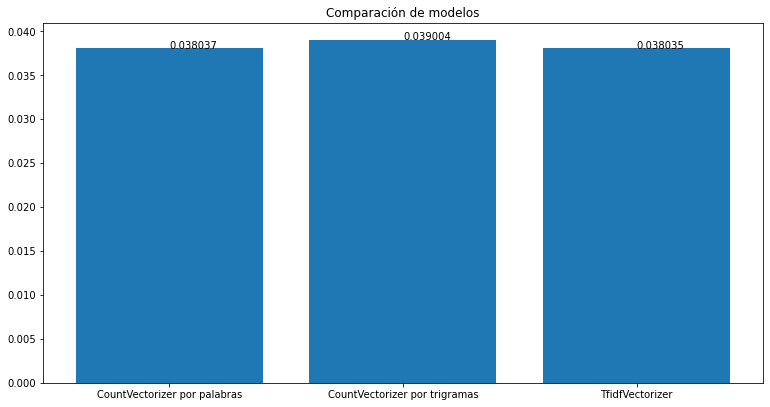

In [98]:
# Celda 5
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos")
ejeX = ['CountVectorizer por palabras', 'CountVectorizer por trigramas','TfidfVectorizer']
ejeY = np.around([mse_1,mse_2,mse_4],6)
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()

Los valores del MSE para los tres modelos trabajados son muy similares, aunque se puede ver que **por mínima diferencia el mejor modelo es el de TfidfVectorizer**. 

Una de los posibles razones para la similitud entre los tres modelos puede estar en la poca variación que se tuvo del único parámetro (*max_depth*) al calibrar el Random Forest con GridSearchCV porque el tiempo de calculo aumentaba de forma que se detenía el proceso sin terminar o dar un resultado. Esperabamos, por lo consultado en el **Punto 3** del laboratorio, que **la tokenización con TfidfVectorizer mostrará una diferencia más marcada respecto a los otros dos métodos utilizados con CountVectorizer** al definir mejor la importancia de cierta palabra para un documento y por lo tanto asociar con mayor claridad las palabras que representan la toxicidad o no de un comentario, y que finalmente esto le permitiera al modelo de Random Forest un mayor poder predictivo.